# CFNet Model with eye disease data

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Layer, MaxPooling2D, Conv2D, Reshape,Dropout
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import scipy.stats as st
from visualization_functions import *
import itertools
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sys
import argparse
import os
import glob 
import scipy.ndimage as sp
from PIL import Image
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import dcor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# importing data
df = pd.read_csv('C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/df_labels.csv')
df.head(5)

,Unnamed: 0,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight,fil_path,file_path
0,0,amd_1101816_1,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
1,1,amd_1101816_2,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
2,2,amd_1101816_3,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
3,3,amd_1101816_4,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
4,4,amd_1191668_1,1,intermediate,MNV_suspected,1191668,OD,F,1948,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...


### Data Augmentation Explanation

This function augments the dataset by applying geometric transformations to images, enhancing data diversity and improving model robustness:

- **Inputs**:
  - `df`: DataFrame with image file paths (`file_path`), ages (`age`), and disease labels (`disease`).
  - `n`: Desired number of samples per class post-augmentation.

- **Process**:
  1. **Image Processing**:
     - Converts each image to grayscale and resizes it to 512x512 using `process_image`.

  2. **Extract Data**:
     - Extracts ages and disease labels into arrays from the DataFrame.

  3. **Augmentation Logic**:
     - Splits data into positive and negative groups based on disease presence.
     - Checks if additional samples are needed to reach the desired count `n`.
     - Generates new samples by:
       - **Rotation**: Randomly rotates images between -5 and +5 degrees.
       - **Translation**: Shifts images randomly within ±5 pixels.
     - Replicates the corresponding ages and labels for new images.

  4. **Data Reintegration**:
     - Merges augmented data back with original data for both classes.

- **Outputs**:
  - Augmented arrays of image data, ages, and disease labels.
  - Arrays are converted to `np.int64` type for compatibility and further processing.

This augmentation ensures balanced and diverse data for training, critical for learning robust and generalizable features.

In [3]:


def process_image(image_path):
    """ Load an image from the path, convert to grayscale, and resize to 512x512 pixels. """
    with Image.open(image_path) as img:
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((512, 512), Image.ANTIALIAS)  # Resize the image
        return np.array(img)

n_desired_samples_per_class = 348
def augment_by_transformation(df, n):
    """
    Augment data by applying transformations and handle data from a DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame with columns 'file_path', 'age', and 'disease'.
    n (int): Desired number of augmented samples for each class (0 and 1).
    
    Returns:
    ndarray: Augmented data.
    ndarray: Augmented ages.
    ndarray: Augmented labels.
    """
    data = np.stack(df['file_path'].apply(process_image))
    age = df['year'].to_numpy()
    labels = df['disease'].to_numpy()
    
    def augment_data(class_data, class_age, class_labels, augment_size):
        num_samples = class_data.shape[0]
        additional_samples = augment_size - num_samples
        
        if additional_samples <= 0:
            return class_data, class_age, class_labels
        
        new_data = np.zeros((additional_samples, 512, 512))
        new_ages = np.zeros(additional_samples)
        new_labels = np.zeros(additional_samples)

        for i in range(additional_samples):
            idx = np.random.randint(0, num_samples)
            new_data[i] = class_data[idx].copy()
            new_data[i] = sp.rotate(new_data[i], angle=np.random.uniform(-5, 5), reshape=False)
            new_data[i] = sp.shift(new_data[i], shift=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)))
            
            new_ages[i] = class_age[idx]
            new_labels[i] = class_labels[idx]

        return np.concatenate((class_data, new_data)), np.concatenate((class_age, new_ages)), np.concatenate((class_labels, new_labels))

    # Separate data into positive and negative instances
    positive_data = data[labels == 1]
    positive_age = age[labels == 1]
    positive_labels = labels[labels == 1]
    
    negative_data = data[labels == 0]
    negative_age = age[labels == 0]
    negative_labels = labels[labels == 0]
    
    # Augment data for positive and negative instances separately
    positive_data_aug, positive_age_aug, positive_labels_aug = augment_data(positive_data, positive_age, positive_labels, n)
    negative_data_aug, negative_age_aug, negative_labels_aug = augment_data(negative_data, negative_age, negative_labels, n)

    # Concatenate augmented data
    data_aug = np.concatenate((positive_data_aug, negative_data_aug), axis=0)
    age_aug = np.concatenate((positive_age_aug, negative_age_aug), axis=0)
    labels_aug = np.concatenate((positive_labels_aug, negative_labels_aug), axis=0)

    return data_aug, age_aug, labels_aug


data_augmented, age_augmented, labels_augmented = augment_by_transformation(df, n_desired_samples_per_class)
age_augmented = age_augmented.astype(np.int64)
labels_augmented = labels_augmented.astype(np.int64)


In [4]:
# displaying number of values in labels
count_ones = np.count_nonzero(labels_augmented)
count_zeros = labels_augmented.size - count_ones

print(f"Number of zeros: {count_zeros}")
print(f"Number of ones: {count_ones}")

# the original labels
print(df['disease'].value_counts())

Number of zeros: 348
Number of ones: 348
1    348
0     70
Name: disease, dtype: int64


Shape of augmented data: (696, 512, 512)
Shape of augmented age: (696,)
Shape of augmented labels: (696,)
Visualizing some of the augmented images:


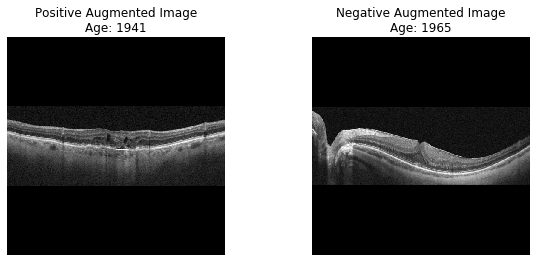

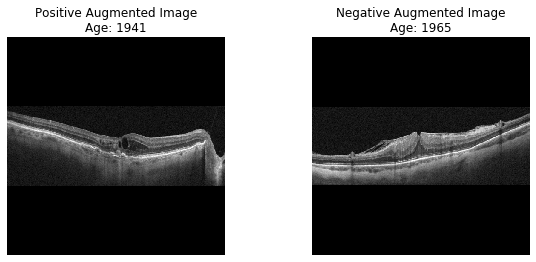

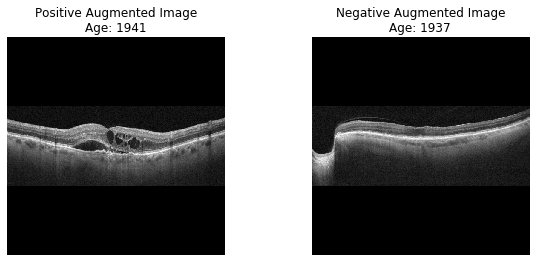

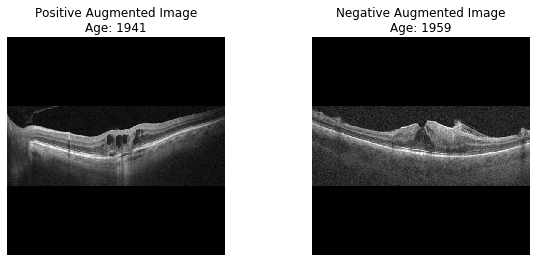

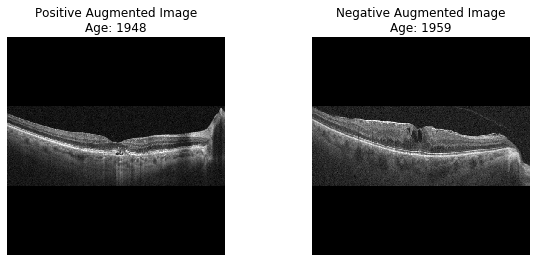

In [5]:
# displayin augmented data
print("Shape of augmented data:", data_augmented.shape)
print("Shape of augmented age:", age_augmented.shape)
print("Shape of augmented labels:", labels_augmented.shape)

# Visualize some of the augmented images
n_samples_to_visualize = 5
print("Visualizing some of the augmented images:")

# Splitting data into positive and negative based on labels for visualization
positive_indices = np.where(labels_augmented == 1)[0]
negative_indices = np.where(labels_augmented == 0)[0]

# Ensure there are enough samples for visualization
positive_indices = positive_indices[:n_samples_to_visualize] if len(positive_indices) >= n_samples_to_visualize else positive_indices
negative_indices = negative_indices[:n_samples_to_visualize] if len(negative_indices) >= n_samples_to_visualize else negative_indices

for i in range(min(len(positive_indices), len(negative_indices))):
    plt.figure(figsize=(10, 4))  # Adjust the figure size if needed
    
    # Visualizing positive samples
    plt.subplot(1, 2, 1)
    plt.imshow(data_augmented[positive_indices[i]].squeeze(), cmap='gray')
    plt.title(f"Positive Augmented Image\nAge: {age_augmented[positive_indices[i]]}")
    plt.axis('off')

    # Visualizing negative samples
    plt.subplot(1, 2, 2)
    plt.imshow(data_augmented[negative_indices[i]].squeeze(), cmap='gray')
    plt.title(f"Negative Augmented Image\nAge: {age_augmented[negative_indices[i]]}")
    plt.axis('off')
    
    plt.show()




### Image Normalization Process

This code snippet normalizes each image in the dataset to enhance model performance:

- **Create a zero-filled array** with the same shape as the original data to store normalized images.
- **Loop through each image**:
  - Calculate the **mean** and **standard deviation** of the image's pixel values.
  - **Normalize**:
    - If the standard deviation is zero, subtract the mean.
    - Otherwise, subtract the mean and divide by the standard deviation.
- Use `tqdm` for a **progress bar** to monitor the normalization process.
- **Output a message** once normalization is complete.

Normalization adjusts the pixel values so that they have a mean of zero and a standard deviation of one, standardizing the input for better model training.


In [6]:
# Normalize each image in the dataset
normalized_data = np.zeros_like(data_augmented)

for i in tqdm(range(len(data_augmented)), desc='Normalizing images'):
    img_data = data_augmented[i]
    mean = np.mean(img_data)
    std = np.std(img_data)
    if std == 0:
        normalized_data[i] = img_data - mean
    else:
        normalized_data[i] = (img_data - mean) / std

print("Normalization complete.")

Normalizing images: 100%|██████████| 696/696 [00:01<00:00, 555.01it/s]

Normalization complete.


In [7]:
# standardixing the age
mean_age = np.mean(age_augmented)
std_age = np.std(age_augmented)

# Standardize the ages
if std_age > 0:  # Checking to avoid division by zero if all ages are the same
    standardized_ages = (age_augmented - mean_age) / std_age
    # Round to 3 decimal places
    standardized_ages = np.round(standardized_ages, 3)
else:
    print("Standard deviation is zero, can't standardize ages")
    standardized_ages = np.zeros_like(age_augmented)  # Use an array of zeros if std_age is zero



In [8]:
# displaying and validating the shapes to put into the model

print("Shape of augmented data:", normalized_data.shape)
print("Shape of augmented age:", standardized_ages.shape)
print("Shape of augmented labels:", labels_augmented.shape)

print('samples from standardized age',np.random.choice(standardized_ages, size=3, replace=False))
print('samples from labels',np.random.choice(labels_augmented, size=3, replace=False))

Shape of augmented data: (696, 512, 512)
Shape of augmented age: (696,)
Shape of augmented labels: (696,)
samples from standardized age [ 0.315 -0.508 -0.825]
samples from labels [1 0 0]


In [9]:
x = normalized_data.reshape(-1, 512, 512, 1)
y = labels_augmented
cf = standardized_ages

In [10]:
# adversial loss for squared correlation 
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

# adversial loss for mse
def inv_mse(y_true, y_pred):
    mse_value = K.sum(K.square(y_true-y_pred))

    return -mse_value

### GAN Class Explanation for Confounder-Free Image Classification

The GAN class in this implementation is designed to first encode images in a way that removes potential confounders, then uses these cleaned images for accurate disease classification:

- **Initialization (`__init__` method)**:
  - **Optimizer Setup**: Initializes separate Adam optimizers for different components of the model, each tailored with specific learning rates for the encoder, distiller, and regressor.
  - **Model Architecture**:
    - **Input Configuration**: Accepts 512x512 grayscale images.
    - **Convolutional Encoder**: Sequentially applies Conv2D and MaxPooling2D layers to extract features, with increasing depth and tanh activation. The use of larger pooling reduces dimensionality more significantly, focusing on more abstract features.
    - **Flattening**: Converts the complex feature maps into a simple 1D array of features, preparing them for regression or classification.
    - **Feature Dimension Capture**: Dynamically determines the output feature dimension after the encoding process to accommodate subsequent model components.

- **Regressor and Distiller Setup**:
  - **Regressor**: Constructs a regressor to predict confounding factors from the encoded features. Once built, it is compiled but set as non-trainable to freeze its weights during certain training phases.
  - **Distiller**: Integrates the encoder and regressor, aiming to adjust the encoder so that the regressor cannot predict confounders effectively, thus 'distilling' the confounder influence out of the features.

- **Classifier Setup**:
  - **Feature Input**: Receives cleaned feature vectors from the encoder.
  - **Classification Layers**: Adds dense layers to perform the final classification, determining whether an image indicates the presence of disease based on confounder-free features.

- **Workflow Integration**:
  - **Combined Model**: Links the encoder, cleaned features, and classifier into a single workflow for end-to-end training, from raw images to disease classification.

- **Training Method (`train_cf`)**:
  - **Data Handling**: Splits provided data into training and testing sets, ensuring even class distribution.
  - **Batch Processing and Epoch Training**: For each epoch, processes data in batches, training the integrated model on confounder-cleaned features, and periodically evaluating model performance using metrics like distance correlation and accuracy.
  - **Performance Evaluation**: After training, evaluates the model on a test set to calculate accuracy and generate a confusion matrix and classification report.

### make changes on this:

In [163]:
# CNN model: three conv-2d layers , Tanh as kernel
# Regressor model: ANN with one hidden Tanh

class GAN():
    
    def __init__(self):
        optimizer = Adam(0.0001)
        optimizer_distiller = Adam(0.0002)
        optimizer_regressor = Adam(0.0002)

        # Adjust the input shape and the model architecture
        input_image = Input(shape=(512, 512, 1), name='input_image')
        

        
        # Updated the model to handle larger images
        feature_dense_enc = Conv2D(16, activation='tanh', kernel_size=(3,3), padding='valid')(input_image)
        feature_dense_enc = MaxPooling2D(pool_size=(4,4))(feature_dense_enc)  # Larger pooling
        feature_dense_enc = Conv2D(32, activation='tanh', kernel_size=(3,3), padding='valid')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D(pool_size=(4,4))(feature_dense_enc)  # Larger pooling
        feature_dense_enc = Conv2D(64, activation='tanh', kernel_size=(3,3), padding='valid')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D(pool_size=(4,4))(feature_dense_enc)  # Larger pooling
        
        feature_dense_enc = Flatten()(feature_dense_enc)
        self.encoder = Model(input_image, feature_dense_enc)

        # Get feature dimension for dynamic handling in classifier and regressor
        sample_output = self.encoder.predict(np.random.normal(size=(1, 512, 512, 1)))  # Generate a random sample input
        feature_dim = sample_output.shape[1]  # This dynamically gets the output size of your encoder

        # Build and compile the bias predictor (encoder fixed)
        self.regressor = self.build_regressor(feature_dim)
        self.regressor.compile(loss='mse', optimizer=optimizer_regressor)
        
        self.regressor.trainable = False
        cf = self.regressor(feature_dense_enc)
        self.distiller = Model(input_image, cf)
        self.distiller.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)
        
        # Build and Compile the classifier with adjusted input feature size
        input_feature_clf = Input(shape=(feature_dim,), name='input_feature_dense')
        feature_clf = Dense(64, activation='tanh')(input_feature_clf)
        prediction_score = Dense(1, name='prediction_score')(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)



        # Build the entire workflow
        prediction_score_workflow = self.classifier(feature_dense_enc)
        label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
        self.workflow = Model(input_image, label_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def build_regressor(self, feature_dim):
        inputs_x = Input(shape=(feature_dim,))
        feature = Dense(32, activation='tanh')(inputs_x)
        cf = Dense(1)(feature)
        return Model(inputs_x, cf)



    def train_cf(self, epochs, training, batch_size=96, fold=0):
        [train_data, train_dx, train_cf] = training

        # Split the data into training and testing sets
        train_data, test_data, train_dx, test_dx, train_cf, test_cf = train_test_split(
          train_data, train_dx, train_cf, test_size=0.2, stratify=train_dx, random_state=42)

            
        # Initialize arrays after determining correct feature dimension dynamically
        feature_dim = self.encoder.output_shape[1]  # Assuming this retrieves the correct dimension
        dc0 = np.zeros((int(epochs/10)+1,))
        dc1 = np.zeros((int(epochs/10)+1,))
        acc = np.zeros((int(epochs/10)+1,))
        feature0 = np.zeros((int(epochs/10)+1, int(train_data.shape[0]/2), feature_dim))  # Corrected initialization
        feature1 = np.zeros((int(epochs/10)+1, int(train_data.shape[0]/2), feature_dim))  # Corrected initialization

        
        for epoch in range(epochs):

            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            ctrl_idx = idx_perm[:int(batch_size)*2]
            
            # Select a random batch for training feature encoder and classifier
            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            idx = idx_perm[:int(batch_size/2)]
            idx = np.concatenate((idx,idx+int(train_data.shape[0]/2)))
            
            training_feature_batch = train_data[idx]
            dx_batch = train_dx[idx]
            cf_batch = train_cf[idx]
        
            
            # ---------------------
            #  Train Encoder & Classifier (actual classification task)
            # ---------------------
            c_loss = self.workflow.train_on_batch(training_feature_batch, dx_batch)


            if epoch % 10 == 0:
                # stratifying between labels
                # analyze distance correlation and learned features for CTRL group
                feature0[int(epoch/10)] = self.encoder.predict(train_data[train_dx == 0][:int(train_data.shape[0]/2)], batch_size=batch_size)
                dc0[int(epoch/10)] = dcor.u_distance_correlation_sqr(feature0[int(epoch/10)], train_cf[train_dx == 0])
                # analyze distance correlation and learned features for Disease group
                feature1[int(epoch/10)] = self.encoder.predict(train_data[train_dx == 1][:int(train_data.shape[0]/2)], batch_size=batch_size)
                dc1[int(epoch/10)] = dcor.u_distance_correlation_sqr(feature1[int(epoch/10)], train_cf[train_dx == 1])
                
                acc[int(epoch/10)] = c_loss[1]
                print ("%d [Acc: %f,  \dc: %f %f]" % (epoch, c_loss[1], dc0[int(epoch/10)], dc1[int(epoch/10)]))

        # After training, predict on the test set
        test_pred = self.workflow.predict(test_data)
        test_pred = (test_pred > 0.5).astype(int)  # Assuming binary classification and sigmoid output

        # Calculate metrics
        test_accuracy = accuracy_score(test_dx, test_pred)
        test_conf_matrix = confusion_matrix(test_dx, test_pred)
        test_class_report = classification_report(test_dx, test_pred)

        print("Test Accuracy:", test_accuracy)
        print("Confusion Matrix:\n", test_conf_matrix)
        print("Classification Report:\n", test_class_report)
        return dc0, dc1, acc, test_dx, test_pred, test_data, test_conf_matrix
    
gan_cf = GAN()
ddc_cf_0, dc_cf_1, acc_cf , test_labels, test_pred, test_data, test_conf_matrix = \
    gan_cf.train_cf(epochs=101, training=[x, y, cf])    

0 [Acc: 0.468750,  \dc: 0.083902 0.066240]
10 [Acc: 0.697917,  \dc: 0.083188 0.067125]
20 [Acc: 0.833333,  \dc: 0.081904 0.068141]
30 [Acc: 0.833333,  \dc: 0.080872 0.069287]
40 [Acc: 0.906250,  \dc: 0.080356 0.071387]
50 [Acc: 0.937500,  \dc: 0.079984 0.072636]
60 [Acc: 0.927083,  \dc: 0.079831 0.073791]
70 [Acc: 0.906250,  \dc: 0.079389 0.074161]
80 [Acc: 0.906250,  \dc: 0.078952 0.073389]
90 [Acc: 0.947917,  \dc: 0.078894 0.074018]
100 [Acc: 0.906250,  \dc: 0.078360 0.073476]
Test Accuracy: 0.8785714285714286
Confusion Matrix:
 [[59 11]
 [ 6 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        70
           1       0.85      0.91      0.88        70

    accuracy                           0.88       140
   macro avg       0.88      0.88      0.88       140
weighted avg       0.88      0.88      0.88       140



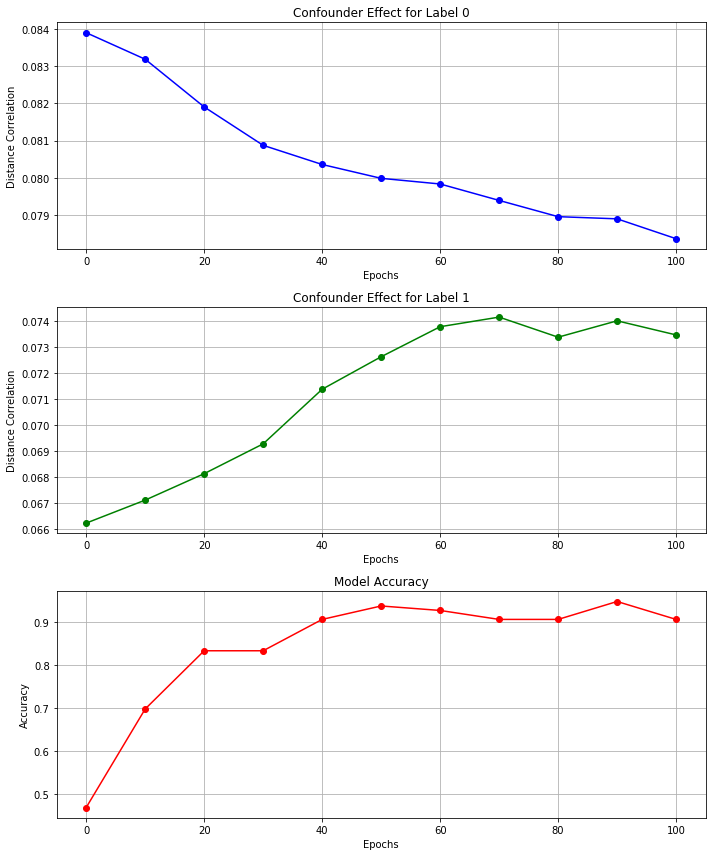

In [164]:
#Plotting the results
epochs = [(i * 10) for i in range(len(ddc_cf_0))]

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.plot(epochs, ddc_cf_0, marker='o', linestyle='-', color='blue')
plt.title('Confounder Effect for Label 0')
plt.xlabel('Epochs')
plt.ylabel('Distance Correlation')

plt.grid(True)
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
plt.plot(epochs, dc_cf_1, marker='o', linestyle='-', color='green')
plt.title('Confounder Effect for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Distance Correlation')

plt.grid(True)
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(epochs, acc_cf, marker='o', linestyle='-', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

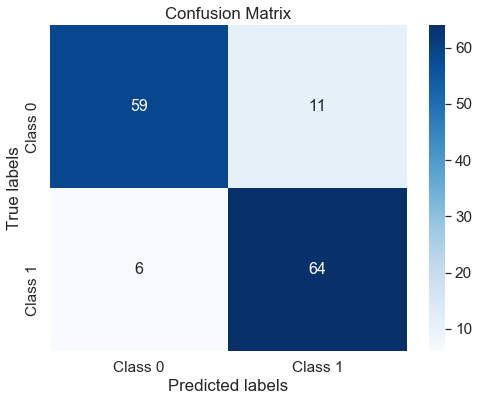

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, labels=['Class 0', 'Class 1']):
    """
    This function plots a styled confusion matrix using seaborn.

    Args:
    cm (list of lists): The confusion matrix data.
    labels (list): The labels of the classes.
    """
    # Create a heatmap from the confusion matrix
    sns.set(font_scale=1.4)  # for label size
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    
    # Adding the labels
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(test_conf_matrix)


### based on VGG 16

In [17]:
# CNN model : VGG-16
# Regressor model: ANN three layers, Relu, Relu, Linear

class GAN():
    
    def __init__(self):
        optimizer = Adam(0.0001)
        optimizer_distiller = Adam(0.0002)
        optimizer_regressor = Adam(0.0002)

        # Adjust the input shape and the model architecture
        input_image = Input(shape=(512, 512, 1), name='input_image')
        

         # VGG-like architecture adapted for 512x512 grayscale images
        feature_dense_enc = Conv2D(64, (3, 3), padding='same', activation='relu')(input_image)
        feature_dense_enc = Conv2D(64, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D((2, 2), strides=(2, 2))(feature_dense_enc)

        feature_dense_enc = Conv2D(128, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(128, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D((2, 2), strides=(2, 2))(feature_dense_enc)

        feature_dense_enc = Conv2D(256, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(256, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(256, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D((2, 2), strides=(2, 2))(feature_dense_enc)

        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D((2, 2), strides=(2, 2))(feature_dense_enc)

        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = Conv2D(512, (3, 3), padding='same', activation='relu')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D((2, 2), strides=(2, 2))(feature_dense_enc)       

        
        feature_dense_enc = Flatten()(feature_dense_enc)
        self.encoder = Model(input_image, feature_dense_enc)

        # Get feature dimension for dynamic handling in classifier and regressor
        sample_output = self.encoder.predict(np.random.normal(size=(1, 512, 512, 1)))  # Generate a random sample input
        feature_dim = sample_output.shape[1]  # This dynamically gets the output size of your encoder

        # Build and compile the bias predictor (encoder fixed)
        self.regressor = self.build_regressor(feature_dim)
        self.regressor.compile(loss='mse', optimizer=optimizer_regressor)
        
        self.regressor.trainable = False
        cf = self.regressor(feature_dense_enc)
        self.distiller = Model(input_image, cf)
        self.distiller.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)
        
        # Build and Compile the classifier with adjusted input feature size
        input_feature_clf = Input(shape=(feature_dim,), name='input_feature_dense')
        feature_clf = Dense(64, activation='tanh')(input_feature_clf)
        prediction_score = Dense(1, name='prediction_score')(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)



        # Build the entire workflow
        prediction_score_workflow = self.classifier(feature_dense_enc)
        label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
        self.workflow = Model(input_image, label_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def build_regressor(self, feature_dim):
        inputs_x = Input(shape=(feature_dim,))
        feature = Dense(64, activation='relu')(inputs_x)  # Increase the number of units and change activation to ReLU
        # feature = Dropout(0.25)(feature)  # Add dropout to reduce overfitting
        feature = Dense(64, activation='relu')(feature)  # Another Dense layer for more complex transformations
        # feature = Dropout(0.25)(feature)  # Add dropout to reduce overfitting
        cf = Dense(1, activation='linear')(feature)  # Output layer with linear activation for regression
        return Model(inputs_x, cf)



    def train_cf(self, epochs, training, batch_size=96, fold=0):
        [train_data, train_dx, train_cf] = training

        # Split the data into training and testing sets
        train_data, test_data, train_dx, test_dx, train_cf, test_cf = train_test_split(
          train_data, train_dx, train_cf, test_size=0.2, stratify=train_dx, random_state=42)

            
        # Initialize arrays after determining correct feature dimension dynamically
        feature_dim = self.encoder.output_shape[1]  # Assuming this retrieves the correct dimension
        dc0 = np.zeros((int(epochs/10)+1,))
        dc1 = np.zeros((int(epochs/10)+1,))
        acc = np.zeros((int(epochs/10)+1,))
        feature0 = np.zeros((int(epochs/10)+1, int(train_data.shape[0]/2), feature_dim))  # Corrected initialization
        feature1 = np.zeros((int(epochs/10)+1, int(train_data.shape[0]/2), feature_dim))  # Corrected initialization

        
        for epoch in range(epochs):
            print(epoch)
            
            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            ctrl_idx = idx_perm[:int(batch_size)*2]
            
            # Select a random batch for training feature encoder and classifier
            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            idx = idx_perm[:int(batch_size/2)]
            idx = np.concatenate((idx,idx+int(train_data.shape[0]/2)))
            
            training_feature_batch = train_data[idx]
            dx_batch = train_dx[idx]
            cf_batch = train_cf[idx]

            # ---------------------
            #  Train Encoder & Classifier (actual classification task)
            # ---------------------
            c_loss = self.workflow.train_on_batch(training_feature_batch, dx_batch)


            if epoch % 10 == 0:
                # stratifying between labels
                # analyze distance correlation and learned features for CTRL group
                feature0[int(epoch/10)] = self.encoder.predict(train_data[train_dx == 0][:int(train_data.shape[0]/2)], batch_size=batch_size)
                dc0[int(epoch/10)] = dcor.u_distance_correlation_sqr(feature0[int(epoch/10)], train_cf[train_dx == 0])
                # analyze distance correlation and learned features for Disease group
                feature1[int(epoch/10)] = self.encoder.predict(train_data[train_dx == 1][:int(train_data.shape[0]/2)], batch_size=batch_size)
                dc1[int(epoch/10)] = dcor.u_distance_correlation_sqr(feature1[int(epoch/10)], train_cf[train_dx == 1])
                
                acc[int(epoch/10)] = c_loss[1]
                print ("%d [Acc: %f,  \dc: %f %f]" % (epoch, c_loss[1], dc0[int(epoch/10)], dc1[int(epoch/10)]))

        # After training, predict on the test set
        test_pred = self.workflow.predict(test_data)
        test_pred = (test_pred > 0.5).astype(int)  # Assuming binary classification and sigmoid output

        # Calculate metrics
        test_accuracy = accuracy_score(test_dx, test_pred)
        test_conf_matrix = confusion_matrix(test_dx, test_pred)
        test_class_report = classification_report(test_dx, test_pred)

        print("Test Accuracy:", test_accuracy)
        print("Confusion Matrix:\n", test_conf_matrix)
        print("Classification Report:\n", test_class_report)
        return dc0, dc1, acc, test_dx, test_pred, test_data, test_conf_matrix
    
gan_cf = GAN()
ddc_cf_0, dc_cf_1, acc_cf , test_labels, test_pred, test_data, test_conf_matrix = \
    gan_cf.train_cf(epochs=101, training=[x, y, cf])    

0
0 [Acc: 0.479167,  \dc: 0.089914 0.043175]
1
2
3
4
5
6
7
8
9
10
10 [Acc: 0.572917,  \dc: 0.088687 0.046955]
11
12
13
14
15
16
17
18
19
20
20 [Acc: 0.927083,  \dc: 0.092193 0.067151]
21
22
23
24
25
26
27
28
29
30
30 [Acc: 0.947917,  \dc: 0.118581 0.082122]
31
32
33
34
35
36
37
38
39
40
40 [Acc: 0.895833,  \dc: 0.115583 0.095223]
41
42
43
44
45
46
47
48
49
50
50 [Acc: 0.979167,  \dc: 0.130939 0.105177]
51
52
53
54
55
56
57
58
59
60
60 [Acc: 0.979167,  \dc: 0.147827 0.071794]
61
62
63
64
65
66
67
68
69
70
70 [Acc: 0.989583,  \dc: 0.133829 0.104386]
71
72
73
74
75
76
77
78
79
80
80 [Acc: 0.989583,  \dc: 0.137624 0.091453]
81
82
83
84
85
86
87
88
89
90
90 [Acc: 1.000000,  \dc: 0.120056 0.099903]
91
92
93
94
95
96
97
98
99
100
100 [Acc: 0.968750,  \dc: 0.132822 0.103735]
Test Accuracy: 0.9857142857142858
Confusion Matrix:
 [[70  0]
 [ 2 68]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        70
           1     

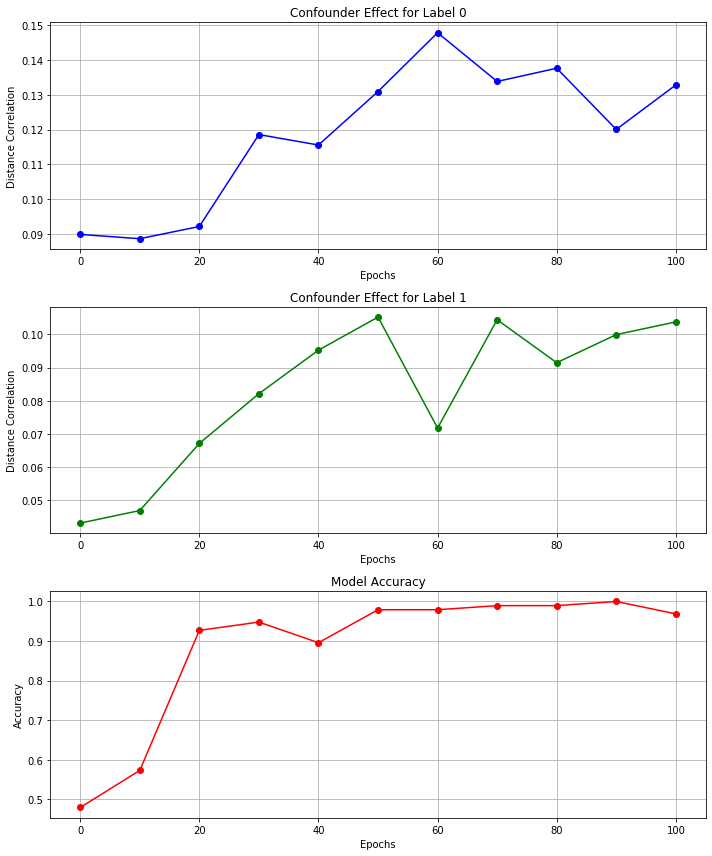

In [6]:
# because of kernel crash we have to rebuild the values from above cell
ddc_cf_0 = [0.089914,  0.088687, 0.092193, 0.118581, 0.115583, 0.130939, 0.147827, 0.133829, 0.137624, 0.120056, 0.132822]
dc_cf_1 = [0.043175, 0.046955, 0.067151, 0.082122, 0.095223, 0.105177, 0.071794, 0.104386, 0.091453, 0.099903, 0.103735]
acc_cf =  [0.479167, 0.572917, 0.927083, 0.947917, 0.895833, 0.979167, 0.979167, 0.989583, 0.989583, 1.000000, 0.968750]
#Plotting the results
epochs = [(i * 10) for i in range(len(ddc_cf_0))]

plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
plt.plot(epochs, ddc_cf_0, marker='o', linestyle='-', color='blue')
plt.title('Confounder Effect for Label 0')
plt.xlabel('Epochs')
plt.ylabel('Distance Correlation')

plt.grid(True)
plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
plt.plot(epochs, dc_cf_1, marker='o', linestyle='-', color='green')
plt.title('Confounder Effect for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Distance Correlation')

plt.grid(True)
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(epochs, acc_cf, marker='o', linestyle='-', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


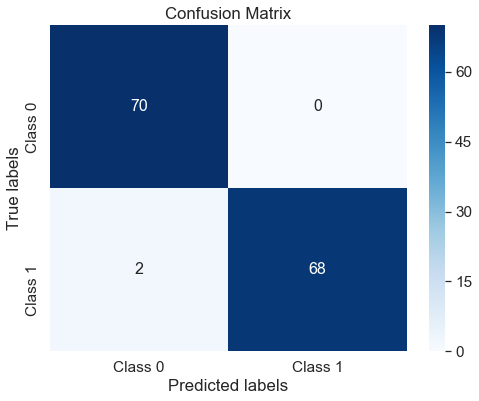

In [8]:
test_conf_matrix = [[70, 0], [2, 68]]
def plot_confusion_matrix(cm, labels=['Class 0', 'Class 1']):
    """
    This function plots a styled confusion matrix using seaborn.

    Args:
    cm (list of lists): The confusion matrix data.
    labels (list): The labels of the classes.
    """
    # Create a heatmap from the confusion matrix
    sns.set(font_scale=1.4)  # for label size
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    
    # Adding the labels
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
# Call the function with your confusion matrix
plot_confusion_matrix(test_conf_matrix)


### End of Notebook